In [1]:
!pip install catboost==1.1
!pip install gcsfs==2022.10.0
!pip install numpy==1.23.4
!pip install pandas==1.5.1
!pip install scikit-learn==1.1.3
!pip install fastparquet
!pip install wandb --upgrade

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/bwhpc/common/jupyter/base/2022-03-30/bin/python3.8 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Using cached gcsfs-2022.10.0-py2.py3-none-any.whl (25 kB)
  Using cached fsspec-2022.10.0-py3-none-any.whl (138 kB)
  Using cached google_auth_oauthlib-0.8.0-py2.py3-none-any.whl (19 kB)
  Using cached google_cloud_storage-2.7.0-py2.py3-none-any.whl (110 kB)
  Using cached google_auth-2.15.0-py2.py3-none-any.whl (177 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached cachetools-5.2.0-py3-none-any.whl (9.3 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached google_resumable_media-2.4.0-py2.py3-none-any.whl (77 kB)
  Using cached google_cloud_core-2.3.2-py2.py3-none-any.whl (29 kB)
  Us

Run `pip install .` first to install all dependencies.

In [2]:
from catboost import CatBoostClassifier

import json

import gcsfs

import numpy as np
import pandas as pd

import os
from pathlib import Path

from sklearn.metrics import accuracy_score
import wandb

from typing import List, Optional

In [4]:
fs = gcsfs.GCSFileSystem(project="thesis")
fs_prefix = "gs://"

/pfs/data5/home/kit/stud/uloak/thesis/thesis/lib64/python3.8/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
features_classical_size = [
    'TRADE_PRICE', 'bid_ask_size_ratio_ex', 'rel_bid_size_ex',
       'rel_ask_size_ex', 'TRADE_SIZE', 'bid_size_ex', 'ask_size_ex',
       'rel_ask_ex', 'rel_bid_ex', 'BEST_rel_bid', 'BEST_rel_ask',
       'bid_ask_ratio_ex', 'chg_ex_lead', 'chg_ex_lag', 'chg_all_lead',
       'chg_all_lag', 'ask_ex', 'bid_ex', 'BEST_ASK', 'BEST_BID',
       'price_all_lag', 'price_all_lead', 'price_ex_lag', 'price_ex_lead'
]

In [7]:
os.environ["GCLOUD_PROJECT"] = "flowing-mantis-239216"

In [45]:
# see https://wandb.ai/fbv/thesis/runs/kwlaw02g/overview?workspace=user-karelze
run = wandb.init(project="thesis",entity="fbv")

dataset = "fbv/thesis/classical_size_features_log_normalized:v0"
artifact = run.use_artifact(dataset)
data_dir = artifact.download()

model = "fbv/thesis/25h1sl6c_CatBoostClassifier_default.cbm:v1"
model_name = model_name = model.split("/")[-1].split(":")[0]

artifact = run.use_artifact(model)
model_dir = artifact.download()

wandb: Downloading large artifact classical_size_features_log_normalized:v0, 2564.04MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:2.7
wandb:   2 of 2 files downloaded.  


In [9]:
X_test = pd.read_parquet(Path(data_dir, "test_set_20.parquet"), engine="fastparquet")

y_test = X_test["buy_sell"]
y_test[y_test<0] = 0
X_test = X_test[features_classical_size]


/scratch/slurm_tmpdir/job_21411297/ipykernel_261027/4082752507.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test[y_test<0] = 0


## CatBoost Baseline 🐈‍⬛

### Learning Curves Baseline 📉

In [23]:
# visualize learning curves
with open(Path(model_dir,model_name[:-4]+"_training.json"), 'r') as j:
     contents = json.loads(j.read())

# extract relevant keys
test_metrics = [d['name'] for d in contents['meta']['test_metrics'] ]
test_results = [d['test'] for d in iterations]
learn_metrics = [d['name'] for d in contents['meta']['learn_metrics'] ]
learn_results = [d['learn'] for d in iterations]

metrics_learn = pd.DataFrame(learn_results, columns=learn_metrics).add_prefix("learn_")
metrics_test = pd.DataFrame(test_results, columns=test_metrics).add_prefix("test_")

learning_metrics = pd.concat([metrics_learn, metrics_test], axis=1)

df.head()

,learn_Accuracy,learn_Logloss,test_Accuracy,test_Logloss
0,0.798642,0.516719,0.685357,0.589861
1,0.810505,0.457868,0.705167,0.568153
2,0.819802,0.430606,0.713258,0.561582
3,0.821254,0.414877,0.715728,0.556678
4,0.822632,0.406146,0.717593,0.553737


<AxesSubplot:>

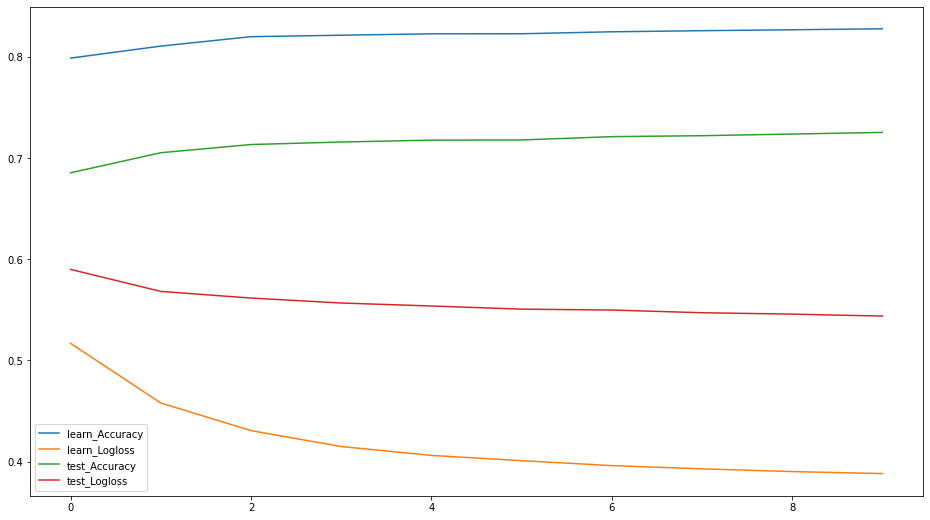

In [25]:
learning_metrics.plot(kind="line", figsize=(16,9))

### Accuracy Baseline 🎯

In [11]:
model = CatBoostClassifier()
model.load_model(fname=Path(model_dir, model_name))

In [12]:
acc = model.score(X_test, y_test)
print(acc)

0.7052623231824203


### Robustness Baseline🥊

In [28]:
# load default data to use unscaled version with all possible columns
X_print = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_extended_20.parquet",
    engine="fastparquet",
    columns=["EXPIRATION", "QUOTE_DATETIME", "OPTION_TYPE", "TRADE_SIZE", "myn", "buy_sell", "issue_type"]
)

In [29]:
# Copy unscaled columns
X_print = X_print.copy()
X_print["buy_sell"] = (X_print["buy_sell"] > 0).astype(int)

# add baseline results
X_print["rule"] = "Baseline"
X_print["buy_sell_predicted"] = model.predict(X_test)

# prepare columns for printing
X_print["ttm"] = (
    X_print["EXPIRATION"].dt.to_period("M")
    - X_print["QUOTE_DATETIME"].dt.to_period("M")
).apply(lambda x: x.n)
X_print["year"] = X_print["QUOTE_DATETIME"].dt.year

bins_tradesize = [-np.inf, 1, 3, 5, 11, np.inf]
trade_size_labels = ["(0,1]", "(1,3]", "(3,5]", "(5,11]", ">11"]
X_print["TRADE_SIZE_binned"] = pd.cut(
    X_print["TRADE_SIZE"], bins_tradesize, labels=trade_size_labels
)

bins_years = [2004, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
year_labels = [
    "2005-2007",
    "2008-2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
]
X_print["year_binned"] = pd.cut(X_print["year"], bins_years, labels=year_labels)

bins_ttm = [-np.inf, 1, 2, 3, 6, 12, np.inf]
ttm_labels = [
    "ttm <= 1 month",
    "ttm (1-2] month",
    "ttm (2-3] month",
    "ttm (3-6] month",
    "ttm (6-12] month",
    "ttm > 12 month",
]
X_print["ttm_binned"] = pd.cut(X_print["ttm"], bins_ttm, labels=ttm_labels)


bins_myn = [-np.inf, 0.7, 0.9, 1.1, 1.3, np.inf]
myn_labels = [
    "mny <=0.7",
    "mny (0.7-0.9]",
    "mny (0.9-1.1]",
    "mny (1.1-1.3]",
    "mny > 1.3",
]
X_print["myn_binned"] = pd.cut(X_print["myn"], bins_myn, labels=myn_labels)

X_print["issue_type_binned"] = X_print["issue_type"].replace(
    {"0": 'Stock options', 'A': 'Index options', '7': 'Others',
     'F': 'Others', '%': 'Others', ' ': 'Others'})


# TODO: time from previous trade; same underlying or any?


In [30]:
X_print.head()

,EXPIRATION,QUOTE_DATETIME,OPTION_TYPE,TRADE_SIZE,myn,buy_sell,issue_type,rule,buy_sell_predicted,ttm,year,TRADE_SIZE_binned,year_binned,ttm_binned,myn_binned,issue_type_binned
39342171,2015-12-18,2015-11-06 09:30:00,P,2,0.921659,0,%,Baseline,0,1,2015,"(1,3]",2015,ttm <= 1 month,mny (0.9-1.1],Others
39342172,2015-11-27,2015-11-06 09:30:00,C,1,1.001696,0,0,Baseline,0,0,2015,"(0,1]",2015,ttm <= 1 month,mny (0.9-1.1],Stock options
39342173,2017-01-20,2015-11-06 09:30:00,C,1,0.886115,0,0,Baseline,0,14,2015,"(0,1]",2015,ttm > 12 month,mny (0.7-0.9],Stock options
39342174,2015-11-20,2015-11-06 09:30:00,C,1,1.009261,1,%,Baseline,1,0,2015,"(0,1]",2015,ttm <= 1 month,mny (0.9-1.1],Others
39342175,2015-12-18,2015-11-06 09:30:00,C,1,0.991880,0,%,Baseline,0,1,2015,"(0,1]",2015,ttm <= 1 month,mny (0.9-1.1],Others


In [31]:
def check_robustness(criterion: str = "year_binned") -> pd.DataFrame:
    """
    Check robustness of rules by calculating the accuracy for a given
    criterion and rules.

    Example:
    rule		Baseline
    TRADE_SIZE_binned
    (0,1]	  0.710966
    (1,3]	  0.717664
    (3,5]	  0.715195
    (5,11]	0.699428
    >11	  	0.688348

    Args:
        criterion (str, optional): criterion to check robustness for.
        Defaults to "year_binned".

    Returns:
        pd.DataFrame: DataFrame with accuracy of rules. Rule in columns and
        criterion values in rows.
    """

    # fill others randomly with equal weight for every class.
    X_print["buy_sell_predicted"] = X_print["buy_sell_predicted"].map(
        lambda l: l if not np.isnan(l) else np.random.choice([0, 1])
    )

    # cuculate average over columns if multiple subsets are combined
    results = (
        X_print.groupby(["rule", criterion])[["buy_sell", "buy_sell_predicted"]]
        .apply(lambda x: accuracy_score(x["buy_sell"], x["buy_sell_predicted"]))
        .unstack(level=0)
        .assign(avg=lambda x: x.mean(axis=1))
    )
    return results


In [32]:
X_print.head()


,EXPIRATION,QUOTE_DATETIME,OPTION_TYPE,TRADE_SIZE,myn,buy_sell,issue_type,rule,buy_sell_predicted,ttm,year,TRADE_SIZE_binned,year_binned,ttm_binned,myn_binned,issue_type_binned
39342171,2015-12-18,2015-11-06 09:30:00,P,2,0.921659,0,%,Baseline,0,1,2015,"(1,3]",2015,ttm <= 1 month,mny (0.9-1.1],Others
39342172,2015-11-27,2015-11-06 09:30:00,C,1,1.001696,0,0,Baseline,0,0,2015,"(0,1]",2015,ttm <= 1 month,mny (0.9-1.1],Stock options
39342173,2017-01-20,2015-11-06 09:30:00,C,1,0.886115,0,0,Baseline,0,14,2015,"(0,1]",2015,ttm > 12 month,mny (0.7-0.9],Stock options
39342174,2015-11-20,2015-11-06 09:30:00,C,1,1.009261,1,%,Baseline,1,0,2015,"(0,1]",2015,ttm <= 1 month,mny (0.9-1.1],Others
39342175,2015-12-18,2015-11-06 09:30:00,C,1,0.991880,0,%,Baseline,0,1,2015,"(0,1]",2015,ttm <= 1 month,mny (0.9-1.1],Others


In [33]:
check_robustness("year_binned")


rule,Baseline,avg
year_binned,,
2015,0.669033,0.669033
2016,0.707365,0.707365
2017,0.712584,0.712584


In [34]:
check_robustness("OPTION_TYPE")


rule,Baseline,avg
OPTION_TYPE,,
C,0.701756,0.701756
P,0.709267,0.709267


In [35]:
check_robustness("issue_type_binned")

rule,Baseline,avg
issue_type_binned,,
Index options,0.557855,0.557855
Others,0.749185,0.749185
Stock options,0.689795,0.689795


In [36]:
check_robustness("TRADE_SIZE_binned")


rule,Baseline,avg
TRADE_SIZE_binned,,
"(0,1]",0.710096,0.710096
"(1,3]",0.714009,0.714009
"(3,5]",0.711946,0.711946
"(5,11]",0.703518,0.703518
>11,0.679353,0.679353


In [37]:
check_robustness("ttm_binned")


rule,Baseline,avg
ttm_binned,,
ttm <= 1 month,0.707660,0.707660
ttm (1-2] month,0.711978,0.711978
ttm (2-3] month,0.702906,0.702906
ttm (3-6] month,0.698200,0.698200
ttm (6-12] month,0.698057,0.698057
ttm > 12 month,0.675393,0.675393


In [38]:
check_robustness("myn_binned")


rule,Baseline,avg
myn_binned,,
mny <=0.7,0.708647,0.708647
mny (0.7-0.9],0.723103,0.723103
mny (0.9-1.1],0.712586,0.712586
mny (1.1-1.3],0.636541,0.636541
mny > 1.3,0.607843,0.607843
